## Importing Dependencies

In [60]:
import torch
import argparse
import torch.nn as nn
import models
import os
import numpy as np
from PIL import Image
from IPython.display import display, Image
import torch
import h5py
import random
from torchvision import transforms
from tqdm import tqdm
import webdataset as wds
import utils
from safetensors.torch import load_file
from clip_retrieval.clip_client import ClipClient, Modality

In [3]:
def parse_args(input_args=None):
    parser = argparse.ArgumentParser(description="Brain Voxel MLP")
    parser.add_argument(
        "--model_name", type=str, default="testing",
        help="name of model, used for ckpt saving and wandb logging (if enabled)",
    )
    parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="brainmlp-model",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--s3_dir",
        type=str,
        default="/users/mihirneal/checkpoints/brainmlp",
        help="S3 directly where the checkpoints are offloaded.",
    )
    parser.add_argument(
        "--subj",type=int, default=1, choices=[1,2,5,7],
    )
    parser.add_argument(
        "--batch_size", type=int, default=32,
        help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="wandb",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument(
        "--resume_from_ckpt",action="store_true",
        help="if not using wandb and want to resume from a ckpt",
    )
    parser.add_argument(
        "--mixup_pct",type=float,default=.33,
        help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
    )
    parser.add_argument(
        "--blurry_recon",action="store_true",
        help="whether to output blurry reconstructions",
    )
    parser.add_argument(
        "--depth_recon",action="store_true",
        help="whether to output depth reconstructions",
    )
    parser.add_argument(
        "--blur_scale",type=float,default=100.,
        help="multiply loss from blurry recons by this number",
    )
    parser.add_argument(
        "--depth_scale",type=float,default=100.,
        help="multiply loss from depth recons by this number",
    )
    parser.add_argument(
        "--clip_scale",type=float,default=1.,
        help="multiply contrastive loss by this number",
    )
    parser.add_argument(
        "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
        help="whether to use image augmentation",
    )
    parser.add_argument(
        "--num_epochs",type=int,default=12,
        help="number of epochs of training",
    )
    parser.add_argument(
        "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
    )
    parser.add_argument(
        "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
    )
    parser.add_argument(
        "--ckpt_interval",type=int,default=5,
        help="save backup ckpt and reconstruct every x epochs",
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=128, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument(
        "--test_batch_size", type=int, default=2770, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument("--best_test_loss", default=1e9, type=int, help="Highest loss possible")
    parser.add_argument(
        "--mixed_precision",type=str,default="fp16",
        help="Half floats are faster in operation",
    )
    parser.add_argument(
        "--seed",type=int,default=42,
    )
    parser.add_argument(
        "--clip_seq_dim",type=int,default=256,
    )
    parser.add_argument(
        "--clip_emb_dim",type=int,default=1536,
    )
    parser.add_argument(
        "--hidden_dim",type=int,default=4096,
    )
    parser.add_argument(
        "--max_lr",type=float,default=3e-4,
    )
    parser.add_argument(
        "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="cycle",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cycle, ""cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--tracker_project_name",
        type=str,
        default="BrainMLP",
        help=(
            "The `project_name` argument passed to Accelerator.init_trackers for."
        ),
    )
    parser.add_argument(
        "--use_deepspeed",
        action="store_true",
        help=(
            "Consider using Deepspeed if the dataset can't fit into a single GPU."
            "Deepspeed compatibility is built into acceelerator however, some changes are required which are activated by setting it to True."
        ),
    )

    if input_args is not None:
        args = parser.parse_args(input_args)
    else:
        args = parser.parse_args()

    return args

In [10]:
data_dir = "/fsx/proj-fmri/shared/mindeyev2_dataset"
model_name = "clip"

jupyter_args = (
    f"--data_path={data_dir} "
    f"--model_name={model_name} "
    f"--output_dir=/fsx/proj-fmri/mihirneal/MindEyeV2/src/train_logs/{model_name} "
    f"--subj=1 "
    f"--batch_size=128 "
    f"--mixup_pct=.66 "
    f"--num_epochs=12 "
    f"--clip_seq_dim=257 "
    f"--clip_emb_dim=768 "
    f"--ckpt_interval=999 "
    f"--no-use_image_aug "
    f"--report_to=wandb "
    f"--blurry_recon "
    f"--depth_recon "
    f"--use_deepspeed"
)
jupyter_args = jupyter_args.split()

In [11]:
args = parse_args(jupyter_args)
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [43]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
from models import Clipper
clip_model = Clipper("ViT-L/14", device=device, hidden_state=True, norm_embs=True)
clip_seq_dim = 257
clip_emb_dim = 768 #1024
hidden_dim = 4096 #* 2


ViT-L/14 cuda


In [17]:
if subj==1:
    num_train = 24958
    num_test = 2770
test_batch_size = num_test

def my_split_by_node(urls): return urls
    
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..36}.tar"
train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])


In [19]:
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False, drop_last=True, pin_memory=True)

In [22]:
test_vox_indices = []
test_73k_images = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_vox_indices = np.append(test_vox_indices, behav[:,0,5].cpu().numpy())
    test_73k_images = np.append(test_73k_images, behav[:,0,0].cpu().numpy())
test_vox_indices = test_vox_indices.astype(np.int16)
print(test_i, (test_i+1) * test_batch_size, len(test_vox_indices))
print("---\n")

train_vox_indices = []
train_73k_images = []
for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
    train_vox_indices = np.append(train_vox_indices, behav[:,0,5].long().cpu().numpy())
    train_73k_images = np.append(train_73k_images, behav[:,0,0].cpu().numpy())
train_vox_indices = train_vox_indices.astype(np.int16)
print(train_i, (train_i+1) * batch_size, len(train_vox_indices))

all_vox_indices = np.hstack((train_vox_indices, test_vox_indices))
all_images = np.hstack((train_73k_images, test_73k_images))

0 2770 2770
---

194 24960 24960


In [29]:
f = h5py.File(f'{data_path}/betas_all_subj0{subj}.hdf5', 'r')

voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").to(torch.float16)
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(torch.float16)
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([27750, 15724])
images torch.Size([73000, 3, 224, 224])


In [48]:
model = models.MindEyeModule().to(device)
model.ridge = models.RidgeRegression(voxels.shape[1], out_features=args.hidden_dim).to(device)
model.backbone = models.BrainNetwork(args, h=args.hidden_dim, in_dim=args.hidden_dim, clip_size=args.clip_emb_dim, out_dim=args.clip_emb_dim*args.clip_seq_dim, blurry_dim=64*7*7).to(device)

In [71]:
model

MindEyeModule(
  (ridge): RidgeRegression(
    (linear): Linear(in_features=15724, out_features=4096, bias=True)
  )
  (backbone): BrainNetwork(
    (lin0): Linear(in_features=4096, out_features=4096, bias=True)
    (mlp): ModuleList(
      (0-3): 4 x Sequential(
        (0): Linear(in_features=4096, out_features=4096, bias=True)
        (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0.15, inplace=False)
      )
    )
    (blin1): Linear(in_features=4096, out_features=4096, bias=True)
    (bgroupnorm): GroupNorm(1, 256, eps=1e-05, affine=True)
    (bupsampler): Decoder(
      (conv_in): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (up_blocks): ModuleList(
        (0): UpDecoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): LoRACompatibleConv(128, 128, kernel_size=(

In [77]:
model

MindEyeModule(
  (ridge): RidgeRegression(
    (linear): Linear(in_features=15724, out_features=4096, bias=True)
  )
  (backbone): BrainNetwork(
    (lin0): Linear(in_features=4096, out_features=4096, bias=True)
    (mlp): ModuleList(
      (0-3): 4 x Sequential(
        (0): Linear(in_features=4096, out_features=4096, bias=True)
        (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0.15, inplace=False)
      )
    )
    (blin1): Linear(in_features=4096, out_features=4096, bias=True)
    (bgroupnorm): GroupNorm(1, 256, eps=1e-05, affine=True)
    (bupsampler): Decoder(
      (conv_in): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (up_blocks): ModuleList(
        (0): UpDecoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): LoRACompatibleConv(128, 128, kernel_size=(

In [75]:
ckpt_path = "/fsx/proj-fmri/mihirneal/MindEyeV2/train_logs/ND3eFP6wYi_interactive/pytorch_model.bin"
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)

RuntimeError: Error(s) in loading state_dict for MindEyeModule:
	Missing key(s) in state_dict: "backbone.dlin1.weight", "backbone.dlin1.bias", "backbone.dgroupnorm.weight", "backbone.dgroupnorm.bias", "backbone.dupsampler.conv_in.weight", "backbone.dupsampler.conv_in.bias", "backbone.dupsampler.up_blocks.0.resnets.0.norm1.weight", "backbone.dupsampler.up_blocks.0.resnets.0.norm1.bias", "backbone.dupsampler.up_blocks.0.resnets.0.conv1.weight", "backbone.dupsampler.up_blocks.0.resnets.0.conv1.bias", "backbone.dupsampler.up_blocks.0.resnets.0.norm2.weight", "backbone.dupsampler.up_blocks.0.resnets.0.norm2.bias", "backbone.dupsampler.up_blocks.0.resnets.0.conv2.weight", "backbone.dupsampler.up_blocks.0.resnets.0.conv2.bias", "backbone.dupsampler.up_blocks.0.resnets.1.norm1.weight", "backbone.dupsampler.up_blocks.0.resnets.1.norm1.bias", "backbone.dupsampler.up_blocks.0.resnets.1.conv1.weight", "backbone.dupsampler.up_blocks.0.resnets.1.conv1.bias", "backbone.dupsampler.up_blocks.0.resnets.1.norm2.weight", "backbone.dupsampler.up_blocks.0.resnets.1.norm2.bias", "backbone.dupsampler.up_blocks.0.resnets.1.conv2.weight", "backbone.dupsampler.up_blocks.0.resnets.1.conv2.bias", "backbone.dupsampler.up_blocks.0.upsamplers.0.conv.weight", "backbone.dupsampler.up_blocks.0.upsamplers.0.conv.bias", "backbone.dupsampler.up_blocks.1.resnets.0.norm1.weight", "backbone.dupsampler.up_blocks.1.resnets.0.norm1.bias", "backbone.dupsampler.up_blocks.1.resnets.0.conv1.weight", "backbone.dupsampler.up_blocks.1.resnets.0.conv1.bias", "backbone.dupsampler.up_blocks.1.resnets.0.norm2.weight", "backbone.dupsampler.up_blocks.1.resnets.0.norm2.bias", "backbone.dupsampler.up_blocks.1.resnets.0.conv2.weight", "backbone.dupsampler.up_blocks.1.resnets.0.conv2.bias", "backbone.dupsampler.up_blocks.1.resnets.0.conv_shortcut.weight", "backbone.dupsampler.up_blocks.1.resnets.0.conv_shortcut.bias", "backbone.dupsampler.up_blocks.1.resnets.1.norm1.weight", "backbone.dupsampler.up_blocks.1.resnets.1.norm1.bias", "backbone.dupsampler.up_blocks.1.resnets.1.conv1.weight", "backbone.dupsampler.up_blocks.1.resnets.1.conv1.bias", "backbone.dupsampler.up_blocks.1.resnets.1.norm2.weight", "backbone.dupsampler.up_blocks.1.resnets.1.norm2.bias", "backbone.dupsampler.up_blocks.1.resnets.1.conv2.weight", "backbone.dupsampler.up_blocks.1.resnets.1.conv2.bias", "backbone.dupsampler.up_blocks.1.upsamplers.0.conv.weight", "backbone.dupsampler.up_blocks.1.upsamplers.0.conv.bias", "backbone.dupsampler.up_blocks.2.resnets.0.norm1.weight", "backbone.dupsampler.up_blocks.2.resnets.0.norm1.bias", "backbone.dupsampler.up_blocks.2.resnets.0.conv1.weight", "backbone.dupsampler.up_blocks.2.resnets.0.conv1.bias", "backbone.dupsampler.up_blocks.2.resnets.0.norm2.weight", "backbone.dupsampler.up_blocks.2.resnets.0.norm2.bias", "backbone.dupsampler.up_blocks.2.resnets.0.conv2.weight", "backbone.dupsampler.up_blocks.2.resnets.0.conv2.bias", "backbone.dupsampler.up_blocks.2.resnets.0.conv_shortcut.weight", "backbone.dupsampler.up_blocks.2.resnets.0.conv_shortcut.bias", "backbone.dupsampler.up_blocks.2.resnets.1.norm1.weight", "backbone.dupsampler.up_blocks.2.resnets.1.norm1.bias", "backbone.dupsampler.up_blocks.2.resnets.1.conv1.weight", "backbone.dupsampler.up_blocks.2.resnets.1.conv1.bias", "backbone.dupsampler.up_blocks.2.resnets.1.norm2.weight", "backbone.dupsampler.up_blocks.2.resnets.1.norm2.bias", "backbone.dupsampler.up_blocks.2.resnets.1.conv2.weight", "backbone.dupsampler.up_blocks.2.resnets.1.conv2.bias", "backbone.dupsampler.up_blocks.2.upsamplers.0.conv.weight", "backbone.dupsampler.up_blocks.2.upsamplers.0.conv.bias", "backbone.dupsampler.up_blocks.3.resnets.0.norm1.weight", "backbone.dupsampler.up_blocks.3.resnets.0.norm1.bias", "backbone.dupsampler.up_blocks.3.resnets.0.conv1.weight", "backbone.dupsampler.up_blocks.3.resnets.0.conv1.bias", "backbone.dupsampler.up_blocks.3.resnets.0.norm2.weight", "backbone.dupsampler.up_blocks.3.resnets.0.norm2.bias", "backbone.dupsampler.up_blocks.3.resnets.0.conv2.weight", "backbone.dupsampler.up_blocks.3.resnets.0.conv2.bias", "backbone.dupsampler.up_blocks.3.resnets.0.conv_shortcut.weight", "backbone.dupsampler.up_blocks.3.resnets.0.conv_shortcut.bias", "backbone.dupsampler.up_blocks.3.resnets.1.norm1.weight", "backbone.dupsampler.up_blocks.3.resnets.1.norm1.bias", "backbone.dupsampler.up_blocks.3.resnets.1.conv1.weight", "backbone.dupsampler.up_blocks.3.resnets.1.conv1.bias", "backbone.dupsampler.up_blocks.3.resnets.1.norm2.weight", "backbone.dupsampler.up_blocks.3.resnets.1.norm2.bias", "backbone.dupsampler.up_blocks.3.resnets.1.conv2.weight", "backbone.dupsampler.up_blocks.3.resnets.1.conv2.bias", "backbone.dupsampler.mid_block.attentions.0.group_norm.weight", "backbone.dupsampler.mid_block.attentions.0.group_norm.bias", "backbone.dupsampler.mid_block.attentions.0.to_q.weight", "backbone.dupsampler.mid_block.attentions.0.to_q.bias", "backbone.dupsampler.mid_block.attentions.0.to_k.weight", "backbone.dupsampler.mid_block.attentions.0.to_k.bias", "backbone.dupsampler.mid_block.attentions.0.to_v.weight", "backbone.dupsampler.mid_block.attentions.0.to_v.bias", "backbone.dupsampler.mid_block.attentions.0.to_out.0.weight", "backbone.dupsampler.mid_block.attentions.0.to_out.0.bias", "backbone.dupsampler.mid_block.resnets.0.norm1.weight", "backbone.dupsampler.mid_block.resnets.0.norm1.bias", "backbone.dupsampler.mid_block.resnets.0.conv1.weight", "backbone.dupsampler.mid_block.resnets.0.conv1.bias", "backbone.dupsampler.mid_block.resnets.0.norm2.weight", "backbone.dupsampler.mid_block.resnets.0.norm2.bias", "backbone.dupsampler.mid_block.resnets.0.conv2.weight", "backbone.dupsampler.mid_block.resnets.0.conv2.bias", "backbone.dupsampler.mid_block.resnets.1.norm1.weight", "backbone.dupsampler.mid_block.resnets.1.norm1.bias", "backbone.dupsampler.mid_block.resnets.1.conv1.weight", "backbone.dupsampler.mid_block.resnets.1.conv1.bias", "backbone.dupsampler.mid_block.resnets.1.norm2.weight", "backbone.dupsampler.mid_block.resnets.1.norm2.bias", "backbone.dupsampler.mid_block.resnets.1.conv2.weight", "backbone.dupsampler.mid_block.resnets.1.conv2.bias", "backbone.dupsampler.conv_norm_out.weight", "backbone.dupsampler.conv_norm_out.bias", "backbone.dupsampler.conv_out.weight", "backbone.dupsampler.conv_out.bias". 

In [37]:
def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    display(Image(url=url, unconfined=True))

client = ClipClient(
    url="https://knn.laion.ai/knn-service",
    indice_name="laion5B-L-14",
    aesthetic_score=9,
    aesthetic_weight=0.5,
    modality=Modality.IMAGE,
    num_images=10,
)

Original Image (test set)


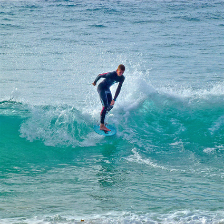

clip_l5b torch.Size([768])
id: 3241094543
caption: 2/21/20 * DAILY SURFING PHOTOS * H.B. PIER
url: https://photos.smugmug.com/photos/i-TfTKgj5/2/S/i-TfTKgj5-S.jpg
similarity: 0.9172650575637817


id: 5375986957
caption: Surfer à Phillip Island en Australie
url: https://soundwaveontheroad.com/wordpress/wp-content/uploads/2014/09/woolamai_surf_australia.jpg
similarity: 0.916541337966919


id: 547281991
caption: Surf!!
url: https://live.staticflickr.com/7198/6821318108_16f2646578_z.jpg
similarity: 0.9151216745376587


id: 156103491
caption: bizkaiko surf txapelketa 2014+%25285%2529.JPG
url: http://1.bp.blogspot.com/-qPSD6cv-hxE/U0J8pKuvwBI/AAAAAAAAmxY/gE0Gygyq15g/s640/bizkaiko-surf-txapelketa-2014.jpg+%25285%2529.JPG
similarity: 0.9130480885505676


id: 895335028
caption: Carlsbad Warm Water Jetty Surf Photos 12/16/18
url: https://photos.smugmug.com/Carlsbad/December-2018/Carlsbad-Warm-Waters-Saturday-16th-December-2018/i-DLzwS8v/0/c4ddeac6/S/DSC_4421-S.jpg
similarity: 0.9126151204109192


In [63]:
ii=2
# # all_indices = np.unique(train_73k_images) #np.hstack((test_vox_indices[ii],train_vox_indices))
test_image, test_voxel = None, None
with torch.no_grad(), torch.cuda.amp.autocast():
    with torch.no_grad(), torch.cuda.amp.autocast(): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test
                
                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[behav[:,0,5].cpu().long()]
                    image = behav[:,0,0].cpu().long()
                    
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = torch.mean(voxel[locs],axis=0)[None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))
#     for batch in tqdm(range(0, 118287, 512)):
#         if batch==0:
#             clip_target = clip_model.embed_image(final_tensor[batch:batch+512]).cpu()
#             # clip_target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
#         else:
#             target = clip_model.embed_image(final_tensor[batch:batch+512]).cpu()
#             # target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
#             clip_target = torch.vstack((clip_target,target))
#     clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    voxel = test_voxel[[ii]].to(device)
    image = test_image[[ii]].to(device)

    print("Original Image (test set)")
    display(utils.torch_to_Image(image))
    
    clip_target = clip_model.embed_image(image).cpu()
    # clip_target_norm = torch.vstack((clip_target_norm, nn.functional.normalize(clip_target.flatten(1), dim=-1)))
    
    voxel_ridge = model.ridge(voxel)
    clip_voxels, _, _ = model.backbone(voxel_ridge)    
    clip_voxels_norm = nn.functional.normalize(clip_voxels, dim=-1)
    clip_voxels_norm = nn.functional.normalize(clip_target, dim=-1)
    clip_l5b = clip_voxels_norm[0, 0, :] 
    print("clip_l5b", clip_l5b.shape)
    # print("clip_target_norm", clip_target_norm.shape)
    ret = client.query(embedding_input=clip_l5b.tolist())
    for i in range(5):
        log_result(ret[i])
    # clip_voxels_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    # print("clip_voxels_norm", clip_voxels_norm.shape)
    # print("clip_target_norm", clip_target_norm.shape)
